## Introduction
In this notebook, we show an example of how to integrate the gas models into mechaFIL.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from datetime import date, timedelta

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from tqdm.auto import tqdm

import numpy as np
import jax.numpy as jnp
import pandas as pd

import mechafil.data as mecha_data
import mechafil.sim as np_sim

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting
import mechafil_jax.date_utils as date_utils
import mechafil_jax.power as power

import scenario_generator.utils as u
import scenario_generator.curated as curated

import cel_utils.disk_utils as du

import gas_models

In [3]:
save_dir = '/Users/kiran/Documents/direct_filp'
cache_dir = '/Users/kiran/Documents/direct_filp/cache'
os.makedirs(save_dir, exist_ok=True)
os.makedirs(cache_dir, exist_ok=True)

In [4]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

start_date = date(2021, 9, 1)  # reduce locking bias by starting sooner
#current_date = date.today() - timedelta(days=3)
current_date = date(2023, 9, 22)  # fix it so that the NB is reproducible
forecast_length = 3*365
end_date = current_date + timedelta(days=forecast_length)
print(start_date, current_date, end_date)


2021-09-01 2023-09-22 2026-09-21


In [5]:
@du.cache_data(directory=cache_dir)
def get_offline_mechafil_data():
    offline_data = data.get_simulation_data(token, start_date, current_date, end_date)
    return {'offline_data': offline_data}
d = get_offline_mechafil_data()
globals().update(d)

## Status-Quo simulation
Here, we run mechafil w/ the current gas model, which just burns the average amount of historical gas burned, every day.

In [6]:
lock_target = 0.3
sector_duration=360

rbp = jnp.ones(forecast_length)*6
rr = jnp.ones(forecast_length)*0.8
fpr = jnp.ones(forecast_length)*0.8

In [7]:
# run status-quo (from gas perspective) simulation
statusquo_results = sim.run_sim(
    rbp,
    rr,
    fpr,
    lock_target,

    start_date,
    current_date,
    forecast_length,
    sector_duration,
    offline_data
)

## Gas update simulation
Here, we generate a gas forecast using the gas models, and integrate that into mechafil

### Train Gas Forecasting Model

In [8]:
# download training data
training_start_date = date(2021, 3, 15)  # since this is TotalGas, we can use all of the data, not just after FIP45 for PSD
training_end_date = current_date

@du.cache_data(directory=cache_dir)
def download_gasusage_data():
    totalgas_df = gas_models.get_daily_gasusage_training_data(training_start_date, training_end_date).dropna()
    return {'totalgas_df': totalgas_df}

d = download_gasusage_data()
globals().update(d)

# first, validate the gas model by splitting historical data into train/test
train_pct = 0.7
n_samp = len(totalgas_df)
n_train = int(n_samp * train_pct)
n_test = n_samp - n_train

totalgas_train_df = totalgas_df.iloc[0:n_train]
totalgas_test_df = totalgas_df.iloc[n_train:]

In [9]:
# train the Gas model
totalgas_arimax_model = gas_models.ArimaxGasModel('total', log_after_scaler=True)
r = totalgas_arimax_model.train_model(totalgas_train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.0
Acceptance rate of Metropolis-Hastings is 0.001025
Acceptance rate of Metropolis-Hastings is 0.167475
Acceptance rate of Metropolis-Hastings is 0.23505

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.22845
Acceptance rate of Metropolis-Hastings is 0.3054
Normal ARIMAX(3,0,2)                                                                                      
======================================================= ==================================================
Dependent Variable: total_gas_used                      Method: Metropolis Hastings                       
Start Date: 4                                           Unnormalized Log Posterior: 2969.5772             
End Date: 644                                           AIC: -5905.154302667028                           
Number of observations: 641                             BIC: -5829.282801899377                           
Latent Variable              

### Train TotalGas <--> BaseFee model


In [10]:
# get training data
# we don't need to restrict to the new PSD gas regime, since this is a general TotalGas <--> BaseFee model
training_start_date = date(2021, 3, 15)
training_end_date = current_date

@du.cache_data(directory=cache_dir)
def get_totalgas_basefee_data():
    df_basefee = gas_models.get_basefee_spacescope(training_start_date, training_end_date)
    df_basefee_daily = df_basefee.groupby(df_basefee['hour_date'].dt.date).mean()
    gas_train_df = gas_models.get_daily_gasusage_training_data(training_start_date, training_end_date)
    basefee_totalgas_df = pd.DataFrame()
    basefee_totalgas_df['daily_base_fee'] = df_basefee_daily['unit_base_fee'].values
    basefee_totalgas_df['total_gas_used'] = gas_train_df['total_gas_used'].values
    return {'basefee_totalgas_df': basefee_totalgas_df}

d = get_totalgas_basefee_data()
globals().update(d)

# remove test data to align TotalGas model and the copula model, for model validation
basefee_totalgas_train_df = basefee_totalgas_df.iloc[0:-n_test]
basefee_totalgas_test_df = basefee_totalgas_df.iloc[-n_test:]

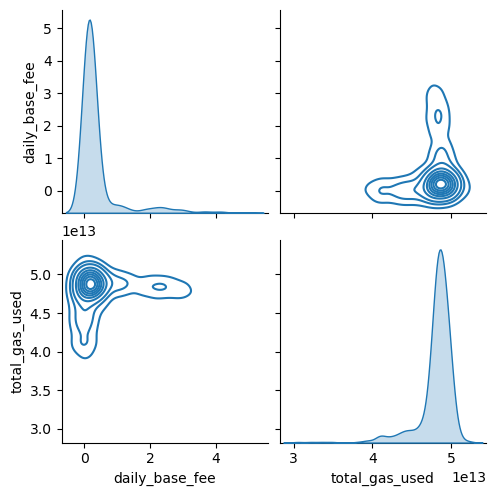

In [11]:
sns.pairplot(basefee_totalgas_train_df, kind='kde')

In [ ]:
# train model
copula_model = gas_models.BivariateCopulaModel(basefee_totalgas_train_df.values)
copula_model.fit()

In [ ]:
# plot some conditional distribution functions to inspect what the copula has learned
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))

gasused_vec = np.asarray([10000, 35000, 40000, 45000, 50000, 55000, 60000])*1e9
for g in gasused_vec:
    (marginal_var, F_cdf), (marginal_var_pseudoobs, conditional_copula_cdf) = \
        copula_model.conditional_distribution(x=None, y=g, resolution=100)
    
    ax[0].plot(marginal_var, F_cdf)
    ax[1].plot(marginal_var_pseudoobs, conditional_copula_cdf, label='TotalGas=%d' % (g//1e9,))

ax[0].set_xlabel('Daily Base Fee (Avg) [nanoFIL]')
ax[0].set_title('H(DailyBaseFee<=x|GasUsed)')
ax[1].set_xlabel('F(Daily Base Fee (Avg) [nanoFIL])')
ax[1].set_title('H(F(DailyBaseFee)<=u|G(GasUsed))')
fig.legend(loc='outside right center')

plt.tight_layout()

## Notice that there's no data for the 10kB gas, and we get some unreasonable results

In [ ]:
def totalgas2basefee(copula_model, total_gas_vec, method='quantile', method_kwargs=None):
    if method == 'quantile':
        if method_kwargs is None:
            qvec = [0.5]
        else:
            qvec = method_kwargs['qvec']
        copula_samples = np.zeros_like(total_gas_vec)
        for ii, g in enumerate(total_gas_vec):
            # [0][1] --> access the F(0.5).  the [0] is b/c qvec is a vector, so get the value of interest.
            copula_samples[ii] = copula_model.quantile_conditional_distribution(x=None, y=g, qvec=qvec)[0]
    elif method == 'sampling':
        if method_kwargs is None:
            nsamp = 100
        else:
            nsamp = method_kwargs['nsamp']
        copula_samples = np.zeros((nsamp, len(total_gas_vec)))
        for ii, g in enumerate(total_gas_vec):
            samps_vec = copula_model.sample_conditional_distribution(x=None, y=g, resolution=100, nsamps=nsamp)
            copula_samples[:,ii] = samps_vec
    else:
        raise ValueError('Invalid method specified!')

    return copula_samples

In [ ]:
# create forecasts
num_mc = 500
ypred_totalgas = totalgas_arimax_model.forecast(totalgas_test_df, num_mc)

# for each median value of ypred_totalgas, compute basefee.
# for now, we compute num_mc samples, and then we can compute bounds on that
median_totalgas = np.median(ypred_totalgas,axis=0)

basefee_samples = np.zeros((num_mc, len(median_totalgas)))
for ii in tqdm(range(num_mc)):
    gas_mc_vec = ypred_totalgas[ii,:]
    copula_median_estimate_basefee = totalgas2basefee(copula_model, gas_mc_vec, method='quantile', method_kwargs = {'qvec': [0.5]})
    basefee_samples[ii,:] = copula_median_estimate_basefee

# compute forecasted protocol revenue
protocol_revenue_mc = np.zeros((num_mc,len(median_totalgas)))
for ii in range(num_mc):
    # the scales cancel out
    gas_forecast = ypred_totalgas[ii,:]*1e-9
    basefee_forecast = basefee_samples[ii,:]
    protocol_revenue_forecast = gas_forecast * basefee_forecast
    protocol_revenue_mc[ii,:] = protocol_revenue_forecast

In [ ]:
# create a forecast for model validation
# plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(11,4))

scale=1e-9
axx = ax[0]
axx.plot(totalgas_test_df['date'], totalgas_test_df['total_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(totalgas_test_df['date'], ypred_totalgas[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.plot(totalgas_test_df['date'], median_totalgas*scale, color='k', label='Median')
axx.set_title('ARIMAX-LogMM')
axx.set_ylabel('GAS (Units of Billions)')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[1]
axx.plot(totalgas_test_df['date'], basefee_totalgas_test_df['daily_base_fee'], color='r', label='True')
quantiles = np.quantile(basefee_samples, axis=0, q=[0.25, 0.5, 0.75])
axx.plot(totalgas_test_df['date'], quantiles[1,:], color='k', label='Median')
axx.fill_between(totalgas_test_df['date'], quantiles[0,:], quantiles[2,:], color='b', alpha=0.2)
axx.set_ylabel('BaseFee (nanoFIL)')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')
axx.set_title('Copula Model: BaseFee <--> TotalGas')

axx = ax[2]
daily_burnt_fil = np.diff(offline_data['burnt_fil_vec'][-n_test-1:])
quantiles = np.quantile(protocol_revenue_mc, axis=0, q=[0.25, 0.5, 0.75])
axx.plot(totalgas_test_df['date'], quantiles[1,:], color='k', label='Median')
axx.fill_between(totalgas_test_df['date'], quantiles[0,:], quantiles[2,:], color='b', alpha=0.2, label='Forecast')
axx.plot(totalgas_test_df['date'], daily_burnt_fil, color='r', label='True')
axx.set_title('Protocol Revenue')
axx.set_ylabel('FIL')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')
axx.legend(loc='upper right')

plt.tight_layout()

## Retrain models w/ full data

### Retrain Gas Forecasting Model

In [ ]:
totalgas_arimax_model = gas_models.ArimaxGasModel('total', log_after_scaler=True)
r = totalgas_arimax_model.train_model(totalgas_df)
r.summary()

### Retrain Copula Model

#### Generate synthetic data for low-total-gas regimes to augment copula training dataset

In [ ]:
# get block level data from Lily

@du.cache_data(directory=cache_dir)
def get_lily_basefee_data():
    df_basefee_lily = gas_models.get_message_gas_economy_lily(HEIGHT=3_000_000)
    df_basefee_lily=df_basefee_lily.sort_values(by='height')
    df_basefee_lily=df_basefee_lily.set_index('height')
    firstBlock=df_basefee_lily.index[0]
    lastBlock=df_basefee_lily.index[-1]
    return {
        'df_basefee_lily': df_basefee_lily,
        'firstBlock': firstBlock,
        'lastBlock': lastBlock
    }

d = get_lily_basefee_data()
globals().update(d)

In [ ]:
# train OU model for simulating gas
basefee_totalgas_tsmodel = gas_models.AvgBaseFeeTotalGasUsageARMAModel(df_basefee_lily)
basefee_totalgas_tsmodel.fit()

In [ ]:
# sample from model at different offsets to simulate different total-gas used regimes

desired_gas_vec = np.linspace(10000, 30000, 25)*1e9

# simulate the data for the different total gas usage
basefee_avg_day, totalgas_day = basefee_totalgas_tsmodel.sample_basefee_avgdaily_totalgas_sumdaily(
    ndays_per_realization=1, 
    nsamps_per_offset=len(train_df)//len(desired_gas_vec), 
    gt_total_vec=desired_gas_vec,
    same_basefee_within_epoch=True
)

# put this into a dataframe
basefee_totalgas_synthetic_df = pd.DataFrame()
basefee_totalgas_synthetic_df['daily_base_fee'] = basefee_avg_day*1e9  # convert to units of nanofil
basefee_totalgas_synthetic_df['total_gas_used'] = totalgas_day

In [ ]:
# create new dataset which combines synthetic and real data
basefee_totalgas_df['type'] = 'real'
basefee_totalgas_synthetic_df['type'] = 'synthetic'
basefee_totalgas_full_df = pd.concat([basefee_totalgas_df, basefee_totalgas_synthetic_df], ignore_index=True)

In [ ]:
sns.pairplot(basefee_totalgas_full_df, kind='kde')

In [ ]:
# train copula model for --> TotalGas & BaseFee
copula_model_full = gas_models.BivariateCopulaModel(basefee_totalgas_full_df[['daily_base_fee', 'total_gas_used']].values)
copula_model_full.fit()

In [ ]:
# plot some conditional distribution functions to inspect what the copula has learned
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))

gasused_vec = np.asarray([10000, 20000, 30000, 40000, 50000, 60000])*1e9
for g in gasused_vec:
    (marginal_var, F_cdf), (marginal_var_pseudoobs, conditional_copula_cdf) = \
        copula_model_full.conditional_distribution(x=None, y=g, resolution=100)

    ax[0].plot(marginal_var, F_cdf)
    ax[1].plot(marginal_var_pseudoobs, conditional_copula_cdf, label='TotalGas=%d' % (g//1e9,))
 
    inv_results = copula_model_full.quantile_conditional_distribution(x=None, y=g, resolution=100, qvec=[0.5])
    print(g/1e9, inv_results)
    
    
ax[0].axhline(0.5, color='k', linestyle='--')
ax[1].axhline(0.5, color='k', linestyle='--')
ax[1].axvline(0.5, color='k', linestyle='--')
ax[0].set_xlabel('Daily Base Fee (Avg) [nanoFIL]')
ax[0].set_title('H(DailyBaseFee<=x|GasUsed)')
ax[1].set_xlabel('F(Daily Base Fee (Avg) [nanoFIL])')
ax[1].set_title('H(F(DailyBaseFee)<=u|G(GasUsed))')
fig.legend(loc='outside right center')

plt.tight_layout()

In [ ]:
# configure the macro simulation
rbp = jnp.ones(forecast_length)*6
rr = jnp.ones(forecast_length)*0.3
fpr = jnp.ones(forecast_length)*0.8

In [ ]:
# now, forecast out the power to get the information needed for forecasting gas
rb_power_zero = offline_data["rb_power_zero"]
qa_power_zero = offline_data["qa_power_zero"]
rb_known_scheduled_expire_vec = offline_data["rb_known_scheduled_expire_vec"]
qa_known_scheduled_expire_vec = offline_data["qa_known_scheduled_expire_vec"]

historical_raw_power_eib = offline_data["historical_raw_power_eib"]
historical_qa_power_eib = offline_data["historical_qa_power_eib"]
historical_onboarded_rb_power_pib = offline_data["historical_onboarded_rb_power_pib"]
historical_onboarded_qa_power_pib = offline_data["historical_onboarded_qa_power_pib"]
historical_renewed_qa_power_pib = offline_data["historical_renewed_qa_power_pib"]
historical_renewed_rb_power_pib = offline_data["historical_renewed_rb_power_pib"]

rb_power_forecast, qa_power_forecast = power.forecast_power_stats(
    rb_power_zero, qa_power_zero, 
    rbp, rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec,
    rr, fpr, sector_duration, forecast_length, 
    fil_plus_m=10.0, qa_renew_relative_multiplier_vec=1.0
)
totalgas_forecast_df = gas_models.get_gasforecast_df(rb_power_forecast, qa_power_forecast, fpr, rr)
totalgas_forecast_df['total_gas_used'] = 0  # will be filled in by the model

In [ ]:
# forecast total gas usage, get the base-fee, and compute the expected protocol revenue
num_mc = 500
ypred_totalgas = totalgas_arimax_model.forecast(totalgas_forecast_df, num_mc)

# for each median value of ypred_totalgas, compute basefee.
# for now, we compute num_mc samples, and then we can compute bounds on that
median_totalgas = np.median(ypred_totalgas,axis=0)

## METHOD 1
# basefee_samples = np.zeros((num_mc, len(median_totalgas)))
# for ii in tqdm(range(num_mc)):
#     gas_mc_vec = ypred_totalgas[ii,:]
#     copula_median_estimate_basefee = totalgas2basefee(copula_model_full, gas_mc_vec, method='quantile', method_kwargs = {'qvec': [0.5]})
#     basefee_samples[ii,:] = copula_median_estimate_basefee

## METHOD 2
basefee_samples = totalgas2basefee(
    copula_model_full, 
    np.median(ypred_totalgas, axis=0), 
    method='sampling', 
    method_kwargs = {'nsamp': num_mc}
)

# compute forecasted protocol revenue
protocol_revenue_mc = np.zeros((num_mc,len(median_totalgas)))
for ii in range(num_mc):
    # the scales cancel out
    gas_forecast = ypred_totalgas[ii,:]*1e-9
    basefee_forecast = basefee_samples[ii,:]
    protocol_revenue_forecast = gas_forecast * basefee_forecast
    protocol_revenue_mc[ii,:] = protocol_revenue_forecast

In [ ]:
t = date_utils.get_t(current_date, forecast_length=forecast_length)
scale=1e-9

# plot the forecasted quantities
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(11,4))

scale=1e-9
axx = ax[0]
quantiles = np.quantile(ypred_totalgas, axis=0, q=[0.25, 0.5, 0.75])
axx.plot(t, quantiles[1,:]*scale, color='k', label='Median')
axx.fill_between(t, quantiles[0,:]*scale, quantiles[2,:]*scale, color='b', alpha=0.2)

axx.set_title('ARIMAX-LogMM')
axx.set_ylabel('GAS (Units of Billions)')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[1]
quantiles = np.quantile(basefee_samples, axis=0, q=[0.25, 0.5, 0.75])
axx.plot(t, quantiles[1,:], color='k', label='Median')
axx.fill_between(t, quantiles[0,:], quantiles[2,:], color='b', alpha=0.2)
axx.set_ylabel('BaseFee (nanoFIL)')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')
axx.set_title('Copula Model: TotalGas <--> BaseFee')

axx = ax[2]
daily_burnt_fil = np.diff(offline_data['burnt_fil_vec'][-n_test-1:])
quantiles = np.quantile(protocol_revenue_mc, axis=0, q=[0.25, 0.5, 0.75])
axx.plot(t, quantiles[1,:], color='k', label='Median')
axx.fill_between(t, quantiles[0,:], quantiles[2,:], color='b', alpha=0.2, label='Q25-Q75')
axx.set_title('Protocol Revenue')
axx.set_ylabel('FIL')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')
axx.legend(loc='upper right')

plt.tight_layout()

### Compare the two